## Set up

In [1]:
sc.install_pypi_package("seaborn")
sc.install_pypi_package("pandas")
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, size, length, split

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1622197718884_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#
sc.install_pypi_package("boto3")
import boto3

s3 = boto3.resource('s3')
bucket = 'amazon-reviews-pds'
bucket_resource = s3.Bucket(bucket)

for obj in bucket_resource.objects.all():
    if 'parquet' in obj.key and 'Books' in obj.key:
        print(obj.last_modified,"\t", round(obj.size * 1e-9), "GB\t",
              obj.key, "\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


2018-04-09 06:35:58+00:00 	 1 GB	 parquet/product_category=Books/part-00000-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:35:59+00:00 	 1 GB	 parquet/product_category=Books/part-00001-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:00+00:00 	 1 GB	 parquet/product_category=Books/part-00002-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:00+00:00 	 1 GB	 parquet/product_category=Books/part-00003-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:00+00:00 	 1 GB	 parquet/product_category=Books/part-00004-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:33+00:00 	 1 GB	 parquet/product_category=Books/part-00005-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:35+00:00 	 1 GB	 parquet/product_category=Books/part-00006-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:35+00:00 	 1 GB	 parquet/product_cate

In [21]:
data = spark.read.parquet('s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet')
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 15
Total Rows: 20726160

## Balancing Data

In [24]:
data = data.withColumn('good_review', (data.star_rating >= 4).cast("integer"))
data.groupBy("good_review").count().orderBy("good_review").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------+
|good_review|   count|
+-----------+--------+
|          0| 3517653|
|          1|17208252|
+-----------+--------+

In [38]:
data = data.sampleBy("good_review", fractions={0: 1, 1: float(3518459/17208252)}, seed=0)
data.groupBy("good_review").count().orderBy("good_review").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------+
|good_review|  count|
+-----------+-------+
|          0|3517653|
|          1|3517653|
+-----------+-------+

## Feature Engineering

In [22]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
tokenizer = Tokenizer(inputCol='review_body', outputCol='text')
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='terms')
#hasher = HashingTF(inputCol=remover.getOutputCol(), outputCol="hash")
#idf = IDF(inputCol=hasher.getOutputCol(), outputCol="review_features")
pipeline = Pipeline(stages=[tokenizer, remover])
data = data.na.drop()
data = pipeline.fit(data).transform(data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

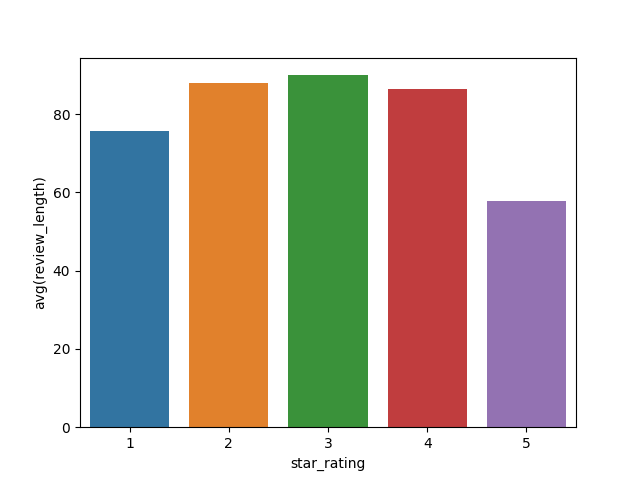

In [7]:
#take a look
review_len = (data.groupBy('star_rating')
                 .mean('review_length')
                 .sort('star_rating', ascending=False)
                )
review_len_df = review_len.toPandas()

sns.barplot(x='star_rating', y="avg(review_length)", data=review_len_df)

In [23]:
#features
data = data.withColumn('helpful_votes', (data.helpful_votes).cast("integer"))
data = data.withColumn('total_votes', (data.total_votes).cast("integer"))
data = data.withColumn('review_length', (size('terms').cast("integer")))
data = data.withColumn('is_vine', (data.vine == "Y").cast('integer'))
data = data.withColumn('is_purchase', (data.verified_purchase == "Y").cast('integer'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
train, test = data.randomSplit([0.7, 0.3])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Build pipeline

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
features = ['helpful_votes', 'total_votes', 
            'review_length', 'is_vine', 'is_purchase']
assembler = VectorAssembler(inputCols = features, outputCol = 'features')
lr = LogisticRegression(featuresCol='features', labelCol='good_review')
pipeline = Pipeline(stages = [assembler, lr])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Cross validation and hypterparameter tuning

In [42]:
paramGrid = ParamGridBuilder() \
    .addGrid(regression.regParam,  np.arange(0, .1, 0.01)) \
    .addGrid(regression.elasticNetParam, [0, 1]) \
    .build()

evaluator = BinaryClassificationEvaluator().setLabelCol('good_review')
cv = CrossValidator(estimator = pipeline,
                    estimatorParamMaps = paramGrid,
                    evaluator = evaluator,
                    numFolds = 5, seed = 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
#because training the full sample takes so long and my network connect is not that stable, 
#I chose to fit the model on a sample.

train_sample = train.sample(fraction=0.0001)
test_sample = test.sample(fraction=0.0001)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
#fit model
model = cv.fit(train_sample)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-44:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 930



In [45]:
#Inspect test and trian AUC
print("Test AUC", evaluator.evaluate(model.transform(test_sample), {evaluator.metricName: "areaUnderROC"}))
print("Train AUC", evaluator.evaluate(model.transform(train_sample), {evaluator.metricName: "areaUnderROC"}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test AUC 0.6728784403669726
Train AUC 0.7605820105820108

In [46]:
#Inspect test result
prediction = model.transform(test_sample)
prediction.groupBy('good_review', 'prediction').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+-----+
|good_review|prediction|count|
+-----------+----------+-----+
|          1|       1.0|   96|
|          0|       0.0|   33|
|          0|       1.0|   63|
|          1|       0.0|   13|
+-----------+----------+-----+

In [47]:
#Inspect train result
prediction_t = model.transform(train_sample)
prediction_t.groupBy('good_review', 'prediction').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+-----+
|good_review|prediction|count|
+-----------+----------+-----+
|          1|       1.0|  228|
|          0|       0.0|  129|
|          0|       1.0|  123|
|          1|       0.0|   30|
+-----------+----------+-----+

In [48]:
trainingSummary = model.bestModel.stages[-1].summary
print("Training AUC: " + str(trainingSummary.areaUnderROC))

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))    
print("\nTraining Accuracy: " + str(trainingSummary.accuracy))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-48:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 5396



Training AUC: 0.7604435831180018

False positive rate by label (Training):
label 0: 0.11627906976744186
label 1: 0.4880952380952381

True positive rate by label (Training):
label 0: 0.5119047619047619
label 1: 0.8837209302325582

Training Accuracy: 0.7